# Úkol č. 4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

## Rozhodovací strom

Náhled dat:

In [2]:
data = pd.read_csv(fr"_data\ukol_04_data.csv")

data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49727,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
49728,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
49729,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
49730,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


Vylistování názvů sloupců (ať se neupíšeme):

In [3]:
list(data.columns)

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'y']

Rozdělení vstupních proměnných na kategoriální a číselné:

In [4]:
categorical_columns = [
                    'job',
                    'marital',
                    'education',
                    'default',
                    'housing',
                    'loan',
                    'contact',
                    'poutcome'
                        ]

numerical_columns = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

y = data["y"]

Konverze kategorických proměnných na číselné:

In [5]:
encoder = OneHotEncoder()
encoded_columns = encoder.fit_transform(data[categorical_columns])


In [6]:
encoder.get_feature_names_out()

array(['job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype=object)

Zobrazení transformovaných kategorických dat v podobě tabulky:

In [7]:
pd.DataFrame(encoded_columns.toarray(), columns=encoder.get_feature_names_out()).head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Spojení obou typů dat do jedné matice:

In [8]:
# proč se funkce "toarray" zobrazuje v editoru jako jediná bíle bez specifikace? :-) 
# Jirka u ní v materiálech zřejmě omylem odkazuje na pandas, ale měla by patřit pod scipy, 
# tady zřejmě pod sklearn? (sparse -> dense array)
encoded_columns = encoded_columns.toarray()

others = data[numerical_columns].to_numpy()

X = np.concatenate([encoded_columns, others], axis= 1)

Rozdělení dat, trénink a vyhodnocení (maximální hloubka stromu omezená na 4 úrovně):

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

# omezení výšky stromu na 4 patra 
clf = DecisionTreeClassifier(max_depth= 4)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Grafický výstup:

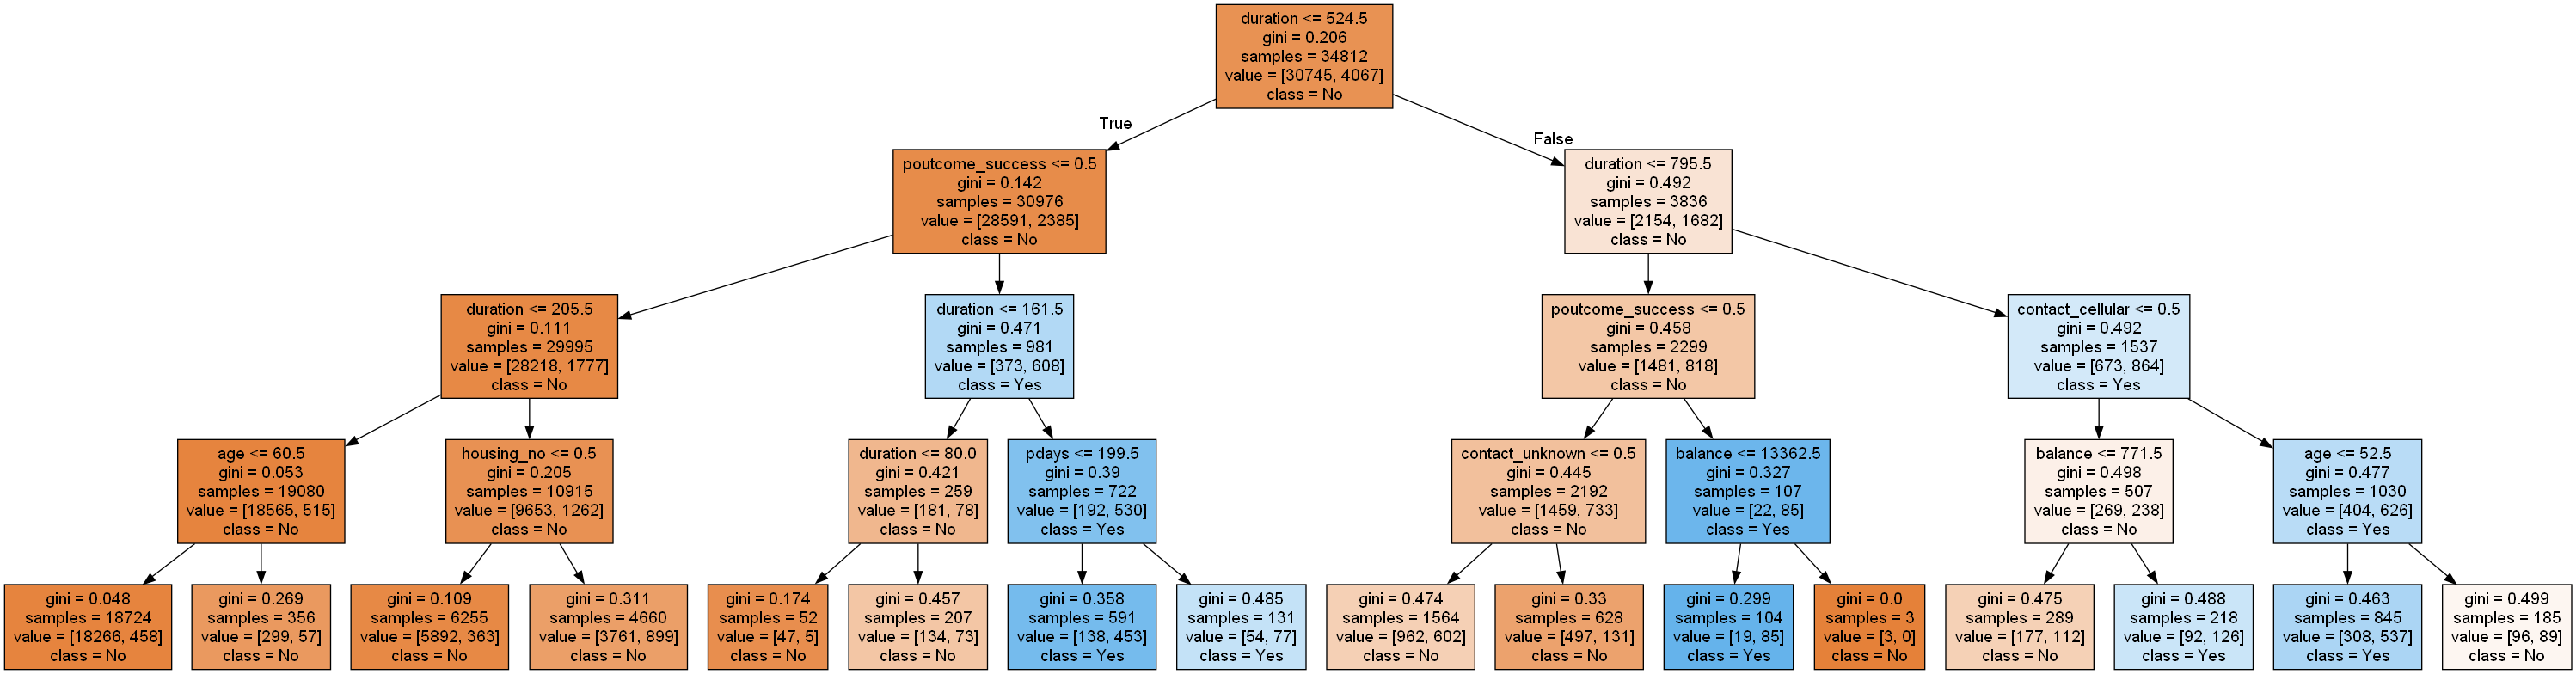

In [10]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, feature_names=list(encoder.get_feature_names_out()) + numerical_columns, class_names=["No", "Yes"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Matice záměn:

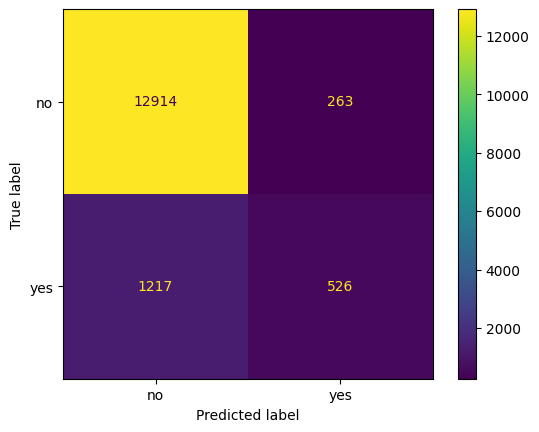

In [11]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

Metrika accuracy:

In [12]:
accuracy_score(y_test, y_pred)

0.900804289544236

## Výběr vhodné metriky pro porovnání algoritmů

Marketingové oddělení banky zajímá metrika "precision", která říká, jaký poměr predikovaných zájemců o termínovaný účet o něj opravdu bude stát (tj. aby true positives byly co nejméně ovlivněny false positives, zatímco false negatives tolik nevadí).

In [13]:
precision_score(y_test, y_pred, pos_label = "yes")

0.6666666666666666

## K-Nearest Neighbours

Standardizace hodnot číselných proměnných (směrodatnou odchylkou):

In [14]:
scaler = StandardScaler()
numeric_data = scaler.fit_transform(data[numerical_columns])

X = np.concatenate([encoded_columns, numeric_data], axis=1)

Rozdělení dat, trénink a vyhodnocení modelu:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

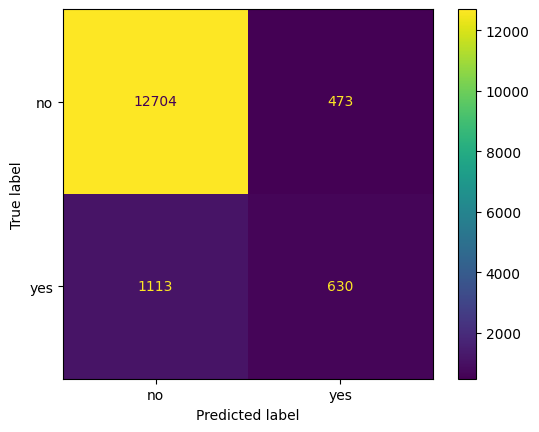

In [16]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

In [17]:
accuracy_score(y_test, y_pred)

0.8936997319034853

Úprava parametrů:

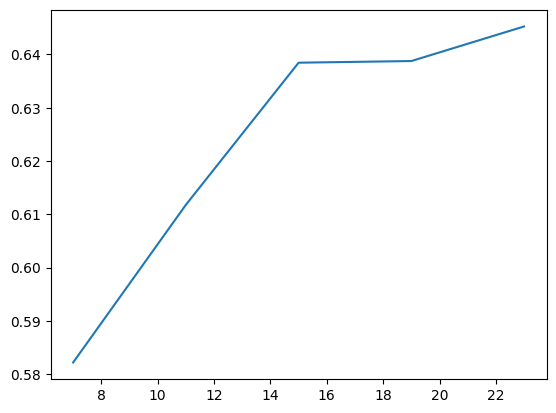

In [18]:
# starý dobrý cyklus :)

ks = range(7, 24, 4)
precision_scores = []

for k in ks:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    precision_scores.append(precision_score(y_test, y_pred, pos_label= "yes"))

plt.plot(ks, precision_scores)

In [19]:
precision_scores

[0.5821917808219178,
 0.6117775354416576,
 0.6384439359267735,
 0.638755980861244,
 0.6452410383189122]

Při úpravě hodnot počtu "sousedů" se hodnota metriky precision postupně navyšuje. Pokud se budeme držet zadání, u nejvyššího doporučeného počtu (23) vykázala hodnotu 64,5 %. Metriku accuracy i precision mírně navýšila hodnota parametru stratify=y při rozdělování dat na trénovací a testovací. Hodnotu metriky precision v případě rozhodovacího stromu však nepřekračuje.

## Support Vector Machine

Úprava a rozdělení dat zůstává z předchozího modelu.

In [20]:
clf = LinearSVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

C:\Users\ivato\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


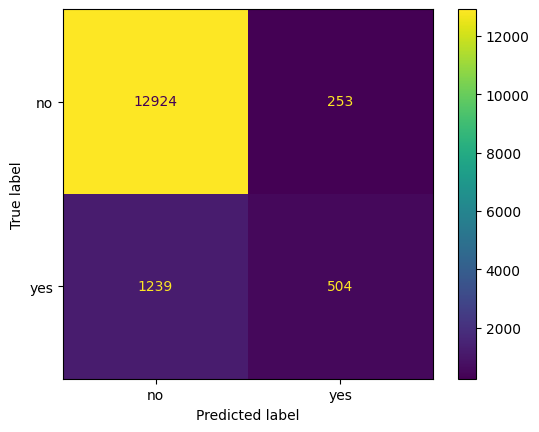

In [21]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

In [22]:
precision_score(y_test, y_pred, pos_label = "yes")

0.665785997357992

## Návrat k testovacímu stromu na závěr

Při porovnání hodnot metriky precision u všech tří využitých algoritmů vychází nejlépe rozhodovací strom. Rozdíly však nejsou velké, úprava některých metrik by mohla pomoci získat ještě lepší výsledek.

Můžeme vyzkoušet, zda není možné zlepšit hodnotu metriky také u algoritmu rozhodovacího stromu, při úpravě maximální hloubky:

In [23]:
X = np.concatenate([encoded_columns, others], axis= 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

max_depth = range(2, 13)
precision_scores = []

for d in max_depth:
    clf = DecisionTreeClassifier(max_depth= d)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    precision_scores.append(precision_score(y_test, y_pred, pos_label= "yes"))
    print(f"max depth {d}: {precision_scores[-1]}")

max depth 2: 0.6047169811320755
max depth 3: 0.6816380449141347
max depth 4: 0.6666666666666666
max depth 5: 0.6678445229681979
max depth 6: 0.6102325581395349
max depth 7: 0.625
max depth 8: 0.6231155778894473
max depth 9: 0.6158878504672897
max depth 10: 0.6224677716390423
max depth 11: 0.5998168498168498
max depth 12: 0.6052393857271906


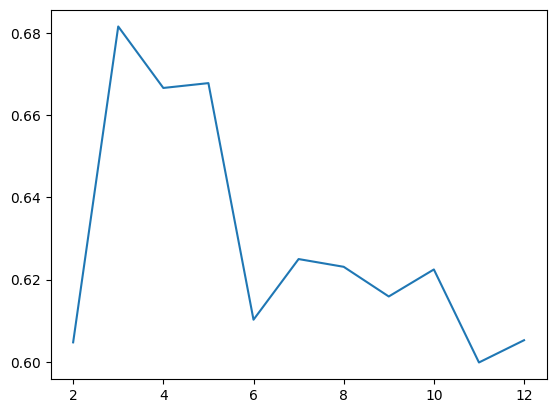

In [24]:
plt.plot(max_depth, precision_scores)

Zdá se, že čím míň pater stromu, tím pro hodnotu metriky precision lépe (až na závěrečnou hloubku 2, kde metrika padá strmě dolů). Pro jistotou ještě accuracy u nejlepší dosažené hodnoty metriky 68,2 % platné pro max hloubku stromu 3:

In [25]:
clf = DecisionTreeClassifier(max_depth= 3)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.9016085790884718

Accuracy se drží stále lehce nad 90 %, aniž by vykázala pokles. Algoritmus rozhodovacího stromu s omezením maximální hloubky na tři úrovně vypadá jako adept na vítěze :)

Zůstávají dvě otázky:
1. Je možné ponechat výstupní proměnnou y tak, jak je, tj. binární yes/no? Není třeba ji převádět explicitně na čísla 1/0?
2. Až teď jsem se podívala do nápovědy, podezřelá je uvedená odlišná hodnota hledané metriky zejména u algoritmu LinearSVC...